## Insights from results

### Insights from Model 1
- Increasing the training samples did not improve the score that much (Re-run with small sample just to check though)
- train: 166159 -> comp_metric at ~ 27 
- train: 536 -> comp_metric at ~ 43.7 (rmse_x: 37.69673776033537 rmse_y: 21.840938110932335 rmse_f: 0.696238586518948)
- For MLP, RMSE was better when trained with 536 samples, at about ~22.4 train loss (with 166159, it was ~ 62 train loss) -> is a prrof that 536 is just too small to be a sample
- Comp metric was way too bad for every model -> lowest was LGBM of ~27 (LB is ~4)
- LGBM has lower score than RF -> Sign of Overfit
- MLP had the worst score with lots of data, and best with small data
- The generated data is just rubbish

### Insights from Model 2
- Running the first 3 test models with n_estimators=1000 at max -> just to see the results quickly
- First run -> rmse_x: 0.85 rmse_y: 0.93 rmse_f: 0.0115 -> comp metric was at 0.97, which is amazing but took a look at feature importance -> it includes "file_id", indicating that most of the "filled" x and y values tend to be the same for many records, so something like file_id becomes a great predictor of x and y -> drop "file_id" and "file_id_le" as they cause leakage
- Second run w/o "file_id" -> rmse_x: 1.52 rmse_y: 1.69 rmse_f: 0.0161 -> comp metric was 1.63 -> more realistic -> timestamp features are in the top -> timestamps, especially "diff_start_wp_ts" is the predictor -> maybe drop timestamps? -> it's only that there aren't enough number of buildings and files that are covered by this training data -> maybe dropping these might enable us to see the "real" predictive power of the model -> but timestamps are included in the test txt files, so only drop "diff_start_wp_ts", which gives constant value with x/y/f -> leak
- Third run, drop "diff_start_wp_ts" -> rmse_x: 1.53 rmse_y: 1.73 rmse_f: 0.0148 -> comp metric was 1.68 -> other timestamps are still strong predictors -> maybe it's not just the timestamps that might be "acting like a leak"
- Fourth run, drop all the timestamp related columns -> to see the predictive power of numerical and categorical features only -> rmse_x: 2.57 rmse_y: 2.69 rmse_f: 0.0559 -> comp metric at 3.11 -> **beacon_ssid > wifi bssid > wifi ssid > wifi rssi > rel_x&rel_y > magn_u_x/y**

### Takeaways
- Likely feature importances -> **beacon_ssid > wifi bssid > wifi ssid > wifi rssi > rel_x&rel_y > magn_u_x/y**
- Problem = multiple records expressing the same x/y/f, is the real problem here
- It doesn't mean "taking the closest waypoint" approach is wrong, it just needs to expressed/filled differently
- Maybe "Fill the gap" strategy needs to be changed from "taking the closest waypoint" to "fill it with averaging or other methods" because it would trigger leakage
- But sometimes "take the closest one" approach might be better. For example, beacon
- **Before we start working on improving the "fill the gap" strategy, we'll try it with test data and try submitting it on LB to see whether this is a valid strategy that we can pursue**

In [1]:
import os
import json
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from PIL import Image, ImageOps
from skimage import io
from skimage.color import rgba2rgb, rgb2xyz
from tqdm import tqdm
from dataclasses import dataclass
from math import floor, ceil
import random

# Train data generation
import collections
import csv
from pathlib import Path
from typing import List, Tuple, Any

import time
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pickle

import math

pd.set_option("display.max_columns", 100)

In [2]:
SEED = 42

In [3]:
dir_path = "../input/indoor2ndtrain/"
# dir_path = "../input/indoorpkl/"
# dir_path = "../input/indoorpkl/"

train_file_name = dir_path + "indoor_train_2.pkl"

# Try loading it back in
with open(train_file_name, "rb") as file:
    df_train = pickle.load(file)

In [4]:
print("df len: ", len(df_train), "\n")
print("site_id value_counts: ", df_train["site_id"].value_counts(), "\n")
print("file_id value_counts: ", df_train["file_id"].value_counts(), "\n")
print("floor value_counts: ", df_train["floor"].value_counts(), "\n")
print("x value_counts: ", df_train["x"].value_counts(), "\n")
print("y value_counts: ", df_train["y"].value_counts(), "\n")
print("event ts nunique: ", df_train["ts"].nunique(), "\n")
print("start ts nunique: ", df_train["start_ts"].nunique(), "\n") # should be same length as file_id
print("diff_ts_wp_ts value_counts: ", df_train["diff_ts_wp_ts"].value_counts(), "\n")
print("diff_ts_wp_ts nunique: ", df_train["diff_ts_wp_ts"].nunique(), "\n")
print("within_500ms value_counts: ", df_train["within_500ms"].value_counts(), "\n")
print("within_1000ms value_counts: ", df_train["within_1000ms"].value_counts(), "\n")
display(df_train.head())

df len:  553753 

site_id value_counts:  5da138764db8ce0c98bcaa46    311520
5cdbc652853bc856e89a8694     82191
5cd56b90e2acfd2d33b5e33f     34670
5cd969d339e2fc0b4afe90f4     31658
5cd56c01e2acfd2d33b698ba     30502
5cd56ba1e2acfd2d33b603af     19336
5cd56b5ae2acfd2d33b58544     16808
5cd969ba39e2fc0b4afe6faf     15014
5cd969e439e2fc0b4afea869      7510
5cd56c0ce2acfd2d33b6ab27      4544
Name: site_id, dtype: int64 

file_id value_counts:  5cf33215866a690008fa1fe0    3691
5cf32f6b866a690008fa1fb7    3322
5cf33feef7d7bc0008343d6c    3306
5daaeb69df065a00069becf3    3138
5dab0636df065a00069bedce    2917
                            ... 
5d0c461d22c7770008a75822      96
5daaf8ce18410e00067e6e03      96
5dac3b83dc3e2c0006606af0      96
5cf765e1e23e6e000833f036      94
5cf765ece23e6e000833f03b      45
Name: file_id, Length: 961, dtype: int64 

floor value_counts:  F1    141989
F2    133464
F3    105716
B1     87718
F4     39023
F5     25277
B2     15149
F6      5417
Name: floor, dtype: int64

,site_id,file_id,floor_converted,floor,ts,start_ts,diff_start_ts,x,y,closest_wp_ts,diff_start_wp_ts,diff_ts_wp_ts,within_500ms,within_1000ms,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,acce_acc,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,ahrs_acc,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_acc,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,gyro_acc,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,acce_u_acc,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,magn_u_acc,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,gyro_u_acc,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_freq,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,floor_converted_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
0,5cd56c0ce2acfd2d33b6ab27,5d09b23fcfb49b00085466aa,2,F3,1.560916e+12,1.560916e+12,197.0,13.726707,22.423597,1.560916e+12,0.0,197.0,True,True,1.560916e+12,197.0,-0.215485,0.691925,9.414001,NaN,1.560916e+12,197.0,0.019111,-0.033138,-0.981493,NaN,1.560916e+12,197.0,-11.880000,-31.619999,-27.90,NaN,43.810601,1.560916e+12,197.0,-0.084213,0.018066,0.016937,NaN,1.560916e+12,197.0,-0.215485,0.691925,9.414001,NaN,1.560916e+12,197.0,16.380001,-32.94,-91.02,NaN,1.560916e+12,197.0,-0.072433,0.039948,0.029831,NaN,1.560916e+12,602.0,b1e32753c8cfd3624253d16d9bc944d917c451e4,8760dd3789b36258dea5d2b3687be70eb2163310,-77.0,NaN,1.560916e+12,1.560916e+12,1976.0,bd1b5cf6d9f4f7bcb796b62cc831b6c81b1aa6ae_356a1...,-97.0,1.560916e+12,1683.0,0.171185,-0.403686,4,238,4,338,552,1007,2019-06-19 03:49:39.027000064,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:49:00,2019-06-19 03:49:26.728,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:49:00
1,5cd56c0ce2acfd2d33b6ab27,5d09b23fcfb49b00085466aa,2,F3,1.560916e+12,1.560916e+12,217.0,13.726707,22.423597,1.560916e+12,0.0,217.0,True,True,1.560916e+12,217.0,-0.287308,0.670380,9.540894,NaN,1.560916e+12,217.0,0.016971,-0.034242,-0.983516,NaN,1.560916e+12,217.0,-11.639999,-31.619999,-27.90,NaN,43.746130,1.560916e+12,217.0,-0.141205,0.004211,0.005219,NaN,1.560916e+12,217.0,-0.215485,0.691925,9.414001,NaN,1.560916e+12,217.0,16.620000,-32.94,-91.02,NaN,1.560916e+12,217.0,-0.098541,0.027710,0.019714,NaN,1.560916e+12,602.0,b1e32753c8cfd3624253d16d9bc944d917c451e4,8760dd3789b36258dea5d2b3687be70eb2163310,-77.0,NaN,1.560916e+12,1.560916e+12,1976.0,bd1b5cf6d9f4f7bcb796b62cc831b6c81b1aa6ae_356a1...,-97.0,1.560916e+12,1683.0,0.171185,-0.403686,4,238,4,338,552,1007,2019-06-19 03:49:39.047000064,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:49:00,2019-06-19 03:49:26.728,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:49:00
2,5cd56c0ce2acfd2d33b6ab27,5d09b23fcfb49b00085466aa,2,F3,1.560916e+12,1.560916e+12,237.0,13.726707,22.423597,1.560916e+12,0.0,237.0,True,True,1.560916e+12,237.0,-0.265762,0.596161,9.758759,NaN,1.560916e+12,237.0,0.020993,-0.031925,-0.983147,NaN,1.560916e+12,237.0,-11.460000,-31.560000,-27.90,NaN,43.655185,1.560916e+12,237.0,-0.175827,0.001541,0.008942,NaN,1.560916e+12,237.0,-0.265762,0.596161,9.758759,NaN,1.560916e+12,237.0,16.800000,-32.88,-91.02,NaN,1.560916e+12,237.0,-0.190155,0.011185,0.011719,NaN,1.560916e+12,602.0,b1e32753c8cfd3624253d16d9bc944d917c451e4,8760dd3789b36258dea5d2b3687be70eb2163310,-77.0,NaN,1.560916e+12,1.560916e+12,1976.0,bd1b5cf6d9f4f7bcb796b62cc831b6c81b1aa6ae_356a1...,-97.0,1.560916e+12,1683.0,0.171185,-0.403686,4,238,4,338,552,1007,2019-06-19 03:49:39.067000064,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:49:00,2019-06-19 03:49:26.728,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:49:00
3,5cd56c0ce2acfd2d33b6ab27,5d09b23fcfb49b00085466aa,2,F3,1.560916e+12,1.560916e+12,257.0,13.726707,22.423597,1.560916e+12,0.0,257.0,True,True,1.560916e+12,257.0,-0.179565,0.550659,9.844955,NaN,1.560916e+12,257.0,0.020695,-0.030332,-0.983186,NaN,1.560916e+12,257.0,-11.460000,-31.380000,-27.66,NaN,43.371783,1.56091

In [5]:
# metric
def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt((xhat - x)**2 + (yhat - y)**2) + 15 * np.abs(fhat-f)
    return intermediate.sum() / xhat.shape[0]

In [6]:
# COnvert floor_converted to integer
df_train["floor_converted"] = df_train["floor_converted"].astype(int)

In [8]:
# column settings
# latter is to drop all the ts related columns
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_converted_le", "file_id", "file_id_le", "diff_start_wp_ts"]
drop_cols = ["floor_converted", "floor", "x", "y", "floor_converted_le", "file_id", "file_id_le", \
             "ts", "start_ts", "diff_start_ts", "closest_wp_ts", "diff_start_wp_ts", "diff_ts_wp_ts", \
             "acce_ts", "diff_acce_ts", "ahrs_ts", "diff_ahrs_ts", "magn_ts", "diff_magn_ts", \
             "gyro_ts", "diff_gyro_ts", "acce_u_ts", "diff_acce_u_ts", "magn_u_ts", "diff_magn_u_ts", \
             "gyro_u_ts", "diff_gyro_u_ts", "wifi_ts", "diff_wifi_ts", "wifi_last_seen_ts", \
             "beacon_ts", "diff_beacon_ts", "rel_ts", "diff_rel_ts", "ts_date", "ts_day", \
             "ts_hour", "ts_minute", "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
             "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"
            ]
categorical_features = ["site_id", "within_500ms", "within_1000ms", "wifi_ssid", "wifi_bssid", "beacon_ssid"]
datetime_features = ["ts_date", "ts_day", "ts_hour", "ts_minute", \
                     "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
                     "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"]

# convert to category from object dtype
for col in categorical_features:
    df_train[col] = df_train[col].astype("category")
    
# convert to int from datetime64 dtype
for col in datetime_features:
    df_train[col] = df_train[col].astype(int)

# set features and labels
# print(df_train.info())

target_x = df_train.iloc[:, 7]
target_y = df_train.iloc[:, 8]
target_f = df_train.iloc[:, 2]
features = df_train.drop(columns=drop_cols)

targets = ["x", "y", "f"]
target_data = [target_x, target_y, target_f]

d = {}
for tgt, tgt_data in zip(targets, target_data):
    feat_train, feat_val, target_train, target_val = \
    train_test_split(features, tgt_data, test_size = 0.2, random_state = 42)
    d["feat_train_{}".format(tgt)] = feat_train
    d["feat_val_{}".format(tgt)] = feat_val
    d["target_train_{}".format(tgt)] = target_train
    d["target_val_{}".format(tgt)] = target_val
    d["train_{}".format(tgt)] = lgb.Dataset(data=feat_train, label=target_train, categorical_feature=categorical_features, free_raw_data=False).construct()
    d["val_{}".format(tgt)] = lgb.Dataset(data=feat_val, label=target_val, categorical_feature=categorical_features, free_raw_data=False).construct()
    print(d["feat_train_{}".format(tgt)].shape)
    print(d["feat_val_{}".format(tgt)].shape)
    print(d["target_train_{}".format(tgt)].shape)
    print(d["target_val_{}".format(tgt)].shape)
    print(d["train_{}".format(tgt)].get_data().shape)
    print(d["train_{}".format(tgt)].get_label().shape)
    print(d["val_{}".format(tgt)].get_data().shape)
    print(d["val_{}".format(tgt)].get_label().shape)

(443002, 44)
(110751, 44)
(443002,)
(110751,)
(443002, 44)
(443002,)
(110751, 44)
(110751,)
(443002, 44)
(110751, 44)
(443002,)
(110751,)
(443002, 44)
(443002,)
(110751, 44)
(110751,)
(443002, 44)
(110751, 44)
(443002,)
(110751,)
(443002, 44)
(443002,)
(110751, 44)
(110751,)


In [9]:
# lgb patams
lgb_params = {'objective': 'root_mean_squared_error',
              'boosting_type': 'gbdt',
              'n_estimators': 1000, # example had 50000
              'learning_rate': 0.1,
              'num_leaves': 50,
              'min_data_in_leaf': 50,
              'max_depth': 10,
              'colsample_bytree': 0.4,
              'subsample': 0.6,
              'subsample_freq': 2,
              'bagging_seed': SEED,
              'reg_alpha': 8,
              'reg_lambda': 2,
              'random_state': SEED,
              'n_jobs': -1
              }

# train models
for tgt in targets:
    model = lgb.train(params=lgb_params,
                      train_set=d["train_{}".format(tgt)],
                      early_stopping_rounds=20,
                      valid_sets=d["val_{}".format(tgt)])
    d["model_{}".format(tgt)] = model
    d["pred_target_{}".format(tgt)] = model.predict(d["feat_val_{}".format(tgt)], 
                                                    num_iteration=model.best_iteration)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9126
[LightGBM] [Info] Number of data points in the train set: 443002, number of used features: 35
[LightGBM] [Info] Start training from score 73.276682
[1]	valid_0's rmse: 41.9635
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 39.2793
[3]	valid_0's rmse: 36.9296
[4]	valid_0's rmse: 35.7168
[5]	valid_0's rmse: 33.7863
[6]	valid_0's rmse: 31.3288
[7]	valid_0's rmse: 29.5478
[8]	valid_0's rmse: 27.7172
[9]	valid_0's rmse: 26.4838
[10]	valid_0's rmse: 24.7071
[11]	valid_0's rmse: 23.8298
[12]	valid_0's rmse: 23.2853
[13]	valid_0's rmse: 22.044
[14]	valid_0's rmse: 20.7948
[15]	valid_0's rmse: 19.9608
[16]	valid_0's rmse: 18.9825
[17]	valid_0's rmse: 17.9995
[18]	valid_0's rmse: 17.7598
[19]	valid_0's rmse: 16.9325
[20]	valid_0's rmse: 16.2996
[21]	valid_0's rmse: 1

[268]	valid_0's rmse: 4.91156
[269]	valid_0's rmse: 4.89701
[270]	valid_0's rmse: 4.89069
[271]	valid_0's rmse: 4.88445
[272]	valid_0's rmse: 4.87593
[273]	valid_0's rmse: 4.86508
[274]	valid_0's rmse: 4.85931
[275]	valid_0's rmse: 4.85225
[276]	valid_0's rmse: 4.84499
[277]	valid_0's rmse: 4.8389
[278]	valid_0's rmse: 4.83104
[279]	valid_0's rmse: 4.82358
[280]	valid_0's rmse: 4.81604
[281]	valid_0's rmse: 4.81179
[282]	valid_0's rmse: 4.79536
[283]	valid_0's rmse: 4.78819
[284]	valid_0's rmse: 4.77962
[285]	valid_0's rmse: 4.76648
[286]	valid_0's rmse: 4.75849
[287]	valid_0's rmse: 4.75127
[288]	valid_0's rmse: 4.74322
[289]	valid_0's rmse: 4.73714
[290]	valid_0's rmse: 4.7322
[291]	valid_0's rmse: 4.72637
[292]	valid_0's rmse: 4.71886
[293]	valid_0's rmse: 4.71393
[294]	valid_0's rmse: 4.70592
[295]	valid_0's rmse: 4.69938
[296]	valid_0's rmse: 4.69381
[297]	valid_0's rmse: 4.68829
[298]	valid_0's rmse: 4.68178
[299]	valid_0's rmse: 4.67601
[300]	valid_0's rmse: 4.67042
[301]	valid_

[547]	valid_0's rmse: 3.52256
[548]	valid_0's rmse: 3.52099
[549]	valid_0's rmse: 3.51568
[550]	valid_0's rmse: 3.50844
[551]	valid_0's rmse: 3.50593
[552]	valid_0's rmse: 3.50276
[553]	valid_0's rmse: 3.50108
[554]	valid_0's rmse: 3.49752
[555]	valid_0's rmse: 3.49255
[556]	valid_0's rmse: 3.48942
[557]	valid_0's rmse: 3.48615
[558]	valid_0's rmse: 3.48359
[559]	valid_0's rmse: 3.48074
[560]	valid_0's rmse: 3.47591
[561]	valid_0's rmse: 3.47015
[562]	valid_0's rmse: 3.46796
[563]	valid_0's rmse: 3.46578
[564]	valid_0's rmse: 3.46442
[565]	valid_0's rmse: 3.4599
[566]	valid_0's rmse: 3.45746
[567]	valid_0's rmse: 3.45509
[568]	valid_0's rmse: 3.45099
[569]	valid_0's rmse: 3.44866
[570]	valid_0's rmse: 3.44611
[571]	valid_0's rmse: 3.44357
[572]	valid_0's rmse: 3.44111
[573]	valid_0's rmse: 3.43739
[574]	valid_0's rmse: 3.43513
[575]	valid_0's rmse: 3.43384
[576]	valid_0's rmse: 3.43126
[577]	valid_0's rmse: 3.42886
[578]	valid_0's rmse: 3.42632
[579]	valid_0's rmse: 3.42374
[580]	valid

[825]	valid_0's rmse: 2.83746
[826]	valid_0's rmse: 2.83589
[827]	valid_0's rmse: 2.83476
[828]	valid_0's rmse: 2.83265
[829]	valid_0's rmse: 2.83086
[830]	valid_0's rmse: 2.82977
[831]	valid_0's rmse: 2.82868
[832]	valid_0's rmse: 2.82663
[833]	valid_0's rmse: 2.82509
[834]	valid_0's rmse: 2.82304
[835]	valid_0's rmse: 2.82142
[836]	valid_0's rmse: 2.82046
[837]	valid_0's rmse: 2.81854
[838]	valid_0's rmse: 2.81555
[839]	valid_0's rmse: 2.81399
[840]	valid_0's rmse: 2.81276
[841]	valid_0's rmse: 2.80927
[842]	valid_0's rmse: 2.80835
[843]	valid_0's rmse: 2.80661
[844]	valid_0's rmse: 2.80406
[845]	valid_0's rmse: 2.80266
[846]	valid_0's rmse: 2.80078
[847]	valid_0's rmse: 2.79881
[848]	valid_0's rmse: 2.79749
[849]	valid_0's rmse: 2.79556
[850]	valid_0's rmse: 2.79353
[851]	valid_0's rmse: 2.79169
[852]	valid_0's rmse: 2.79019
[853]	valid_0's rmse: 2.78826
[854]	valid_0's rmse: 2.78701
[855]	valid_0's rmse: 2.78555
[856]	valid_0's rmse: 2.7842
[857]	valid_0's rmse: 2.78267
[858]	valid

[87]	valid_0's rmse: 8.06383
[88]	valid_0's rmse: 8.02245
[89]	valid_0's rmse: 7.99584
[90]	valid_0's rmse: 7.97704
[91]	valid_0's rmse: 7.95746
[92]	valid_0's rmse: 7.93977
[93]	valid_0's rmse: 7.89338
[94]	valid_0's rmse: 7.85617
[95]	valid_0's rmse: 7.80463
[96]	valid_0's rmse: 7.7481
[97]	valid_0's rmse: 7.71397
[98]	valid_0's rmse: 7.66837
[99]	valid_0's rmse: 7.63588
[100]	valid_0's rmse: 7.58446
[101]	valid_0's rmse: 7.55064
[102]	valid_0's rmse: 7.52159
[103]	valid_0's rmse: 7.50347
[104]	valid_0's rmse: 7.46473
[105]	valid_0's rmse: 7.42694
[106]	valid_0's rmse: 7.38777
[107]	valid_0's rmse: 7.35167
[108]	valid_0's rmse: 7.33921
[109]	valid_0's rmse: 7.31473
[110]	valid_0's rmse: 7.29909
[111]	valid_0's rmse: 7.26853
[112]	valid_0's rmse: 7.2368
[113]	valid_0's rmse: 7.21774
[114]	valid_0's rmse: 7.18865
[115]	valid_0's rmse: 7.16477
[116]	valid_0's rmse: 7.13845
[117]	valid_0's rmse: 7.12345
[118]	valid_0's rmse: 7.1012
[119]	valid_0's rmse: 7.07926
[120]	valid_0's rmse: 7.05

[363]	valid_0's rmse: 4.40042
[364]	valid_0's rmse: 4.3957
[365]	valid_0's rmse: 4.38925
[366]	valid_0's rmse: 4.38528
[367]	valid_0's rmse: 4.37884
[368]	valid_0's rmse: 4.37165
[369]	valid_0's rmse: 4.36767
[370]	valid_0's rmse: 4.36318
[371]	valid_0's rmse: 4.35898
[372]	valid_0's rmse: 4.35375
[373]	valid_0's rmse: 4.34864
[374]	valid_0's rmse: 4.34376
[375]	valid_0's rmse: 4.34012
[376]	valid_0's rmse: 4.33551
[377]	valid_0's rmse: 4.32703
[378]	valid_0's rmse: 4.32278
[379]	valid_0's rmse: 4.31857
[380]	valid_0's rmse: 4.31329
[381]	valid_0's rmse: 4.30896
[382]	valid_0's rmse: 4.30514
[383]	valid_0's rmse: 4.29715
[384]	valid_0's rmse: 4.29157
[385]	valid_0's rmse: 4.28642
[386]	valid_0's rmse: 4.28324
[387]	valid_0's rmse: 4.27496
[388]	valid_0's rmse: 4.27141
[389]	valid_0's rmse: 4.26346
[390]	valid_0's rmse: 4.2587
[391]	valid_0's rmse: 4.25554
[392]	valid_0's rmse: 4.24949
[393]	valid_0's rmse: 4.24348
[394]	valid_0's rmse: 4.23928
[395]	valid_0's rmse: 4.23336
[396]	valid_

[641]	valid_0's rmse: 3.35262
[642]	valid_0's rmse: 3.35078
[643]	valid_0's rmse: 3.34814
[644]	valid_0's rmse: 3.34438
[645]	valid_0's rmse: 3.34211
[646]	valid_0's rmse: 3.33977
[647]	valid_0's rmse: 3.33705
[648]	valid_0's rmse: 3.33546
[649]	valid_0's rmse: 3.33327
[650]	valid_0's rmse: 3.33164
[651]	valid_0's rmse: 3.32976
[652]	valid_0's rmse: 3.32725
[653]	valid_0's rmse: 3.3245
[654]	valid_0's rmse: 3.32267
[655]	valid_0's rmse: 3.32139
[656]	valid_0's rmse: 3.31887
[657]	valid_0's rmse: 3.31643
[658]	valid_0's rmse: 3.3141
[659]	valid_0's rmse: 3.31191
[660]	valid_0's rmse: 3.31038
[661]	valid_0's rmse: 3.30705
[662]	valid_0's rmse: 3.30542
[663]	valid_0's rmse: 3.30304
[664]	valid_0's rmse: 3.30074
[665]	valid_0's rmse: 3.29694
[666]	valid_0's rmse: 3.29529
[667]	valid_0's rmse: 3.29215
[668]	valid_0's rmse: 3.29097
[669]	valid_0's rmse: 3.2875
[670]	valid_0's rmse: 3.28415
[671]	valid_0's rmse: 3.28183
[672]	valid_0's rmse: 3.27935
[673]	valid_0's rmse: 3.27777
[674]	valid_0

[920]	valid_0's rmse: 2.80124
[921]	valid_0's rmse: 2.79994
[922]	valid_0's rmse: 2.7984
[923]	valid_0's rmse: 2.79714
[924]	valid_0's rmse: 2.79594
[925]	valid_0's rmse: 2.79426
[926]	valid_0's rmse: 2.79368
[927]	valid_0's rmse: 2.7925
[928]	valid_0's rmse: 2.7912
[929]	valid_0's rmse: 2.78995
[930]	valid_0's rmse: 2.78768
[931]	valid_0's rmse: 2.78589
[932]	valid_0's rmse: 2.78503
[933]	valid_0's rmse: 2.7839
[934]	valid_0's rmse: 2.78212
[935]	valid_0's rmse: 2.78055
[936]	valid_0's rmse: 2.77917
[937]	valid_0's rmse: 2.77799
[938]	valid_0's rmse: 2.77701
[939]	valid_0's rmse: 2.7752
[940]	valid_0's rmse: 2.77408
[941]	valid_0's rmse: 2.77247
[942]	valid_0's rmse: 2.77116
[943]	valid_0's rmse: 2.77009
[944]	valid_0's rmse: 2.7679
[945]	valid_0's rmse: 2.76662
[946]	valid_0's rmse: 2.76529
[947]	valid_0's rmse: 2.76406
[948]	valid_0's rmse: 2.76302
[949]	valid_0's rmse: 2.76117
[950]	valid_0's rmse: 2.75913
[951]	valid_0's rmse: 2.75719
[952]	valid_0's rmse: 2.75578
[953]	valid_0's 

[151]	valid_0's rmse: 0.130142
[152]	valid_0's rmse: 0.129899
[153]	valid_0's rmse: 0.129269
[154]	valid_0's rmse: 0.128987
[155]	valid_0's rmse: 0.128473
[156]	valid_0's rmse: 0.127937
[157]	valid_0's rmse: 0.127488
[158]	valid_0's rmse: 0.127301
[159]	valid_0's rmse: 0.127046
[160]	valid_0's rmse: 0.12664
[161]	valid_0's rmse: 0.126326
[162]	valid_0's rmse: 0.125918
[163]	valid_0's rmse: 0.125485
[164]	valid_0's rmse: 0.124837
[165]	valid_0's rmse: 0.124291
[166]	valid_0's rmse: 0.123997
[167]	valid_0's rmse: 0.123677
[168]	valid_0's rmse: 0.123187
[169]	valid_0's rmse: 0.122982
[170]	valid_0's rmse: 0.122817
[171]	valid_0's rmse: 0.122431
[172]	valid_0's rmse: 0.122286
[173]	valid_0's rmse: 0.121897
[174]	valid_0's rmse: 0.121741
[175]	valid_0's rmse: 0.121423
[176]	valid_0's rmse: 0.121238
[177]	valid_0's rmse: 0.12088
[178]	valid_0's rmse: 0.120428
[179]	valid_0's rmse: 0.120297
[180]	valid_0's rmse: 0.120185
[181]	valid_0's rmse: 0.119998
[182]	valid_0's rmse: 0.1198
[183]	valid_

[412]	valid_0's rmse: 0.080737
[413]	valid_0's rmse: 0.0806397
[414]	valid_0's rmse: 0.0805918
[415]	valid_0's rmse: 0.0804917
[416]	valid_0's rmse: 0.0803884
[417]	valid_0's rmse: 0.0803186
[418]	valid_0's rmse: 0.0802346
[419]	valid_0's rmse: 0.0801653
[420]	valid_0's rmse: 0.0800073
[421]	valid_0's rmse: 0.0799551
[422]	valid_0's rmse: 0.0799161
[423]	valid_0's rmse: 0.079759
[424]	valid_0's rmse: 0.0796916
[425]	valid_0's rmse: 0.079606
[426]	valid_0's rmse: 0.0795248
[427]	valid_0's rmse: 0.0794369
[428]	valid_0's rmse: 0.0794085
[429]	valid_0's rmse: 0.0793537
[430]	valid_0's rmse: 0.0793168
[431]	valid_0's rmse: 0.0792334
[432]	valid_0's rmse: 0.0791891
[433]	valid_0's rmse: 0.0790873
[434]	valid_0's rmse: 0.0790135
[435]	valid_0's rmse: 0.0788947
[436]	valid_0's rmse: 0.0788251
[437]	valid_0's rmse: 0.0787648
[438]	valid_0's rmse: 0.0786821
[439]	valid_0's rmse: 0.0786108
[440]	valid_0's rmse: 0.0785256
[441]	valid_0's rmse: 0.0784299
[442]	valid_0's rmse: 0.0783533
[443]	valid

[669]	valid_0's rmse: 0.065081
[670]	valid_0's rmse: 0.0650222
[671]	valid_0's rmse: 0.0650025
[672]	valid_0's rmse: 0.0649725
[673]	valid_0's rmse: 0.064961
[674]	valid_0's rmse: 0.0648802
[675]	valid_0's rmse: 0.0648297
[676]	valid_0's rmse: 0.0648076
[677]	valid_0's rmse: 0.0647571
[678]	valid_0's rmse: 0.0647398
[679]	valid_0's rmse: 0.0647173
[680]	valid_0's rmse: 0.0646894
[681]	valid_0's rmse: 0.064638
[682]	valid_0's rmse: 0.0645988
[683]	valid_0's rmse: 0.064583
[684]	valid_0's rmse: 0.0644783
[685]	valid_0's rmse: 0.0644375
[686]	valid_0's rmse: 0.0644188
[687]	valid_0's rmse: 0.0643933
[688]	valid_0's rmse: 0.0643514
[689]	valid_0's rmse: 0.0643061
[690]	valid_0's rmse: 0.0642749
[691]	valid_0's rmse: 0.0642505
[692]	valid_0's rmse: 0.0641891
[693]	valid_0's rmse: 0.0641475
[694]	valid_0's rmse: 0.0641283
[695]	valid_0's rmse: 0.0640955
[696]	valid_0's rmse: 0.0640588
[697]	valid_0's rmse: 0.0640414
[698]	valid_0's rmse: 0.0640025
[699]	valid_0's rmse: 0.063992
[700]	valid_0

[925]	valid_0's rmse: 0.0575881
[926]	valid_0's rmse: 0.0575773
[927]	valid_0's rmse: 0.0575618
[928]	valid_0's rmse: 0.0575507
[929]	valid_0's rmse: 0.0575235
[930]	valid_0's rmse: 0.0575066
[931]	valid_0's rmse: 0.0574962
[932]	valid_0's rmse: 0.0574749
[933]	valid_0's rmse: 0.0574535
[934]	valid_0's rmse: 0.0574268
[935]	valid_0's rmse: 0.0574066
[936]	valid_0's rmse: 0.0573771
[937]	valid_0's rmse: 0.057314
[938]	valid_0's rmse: 0.0572845
[939]	valid_0's rmse: 0.0572694
[940]	valid_0's rmse: 0.0572447
[941]	valid_0's rmse: 0.0572291
[942]	valid_0's rmse: 0.0572171
[943]	valid_0's rmse: 0.0572018
[944]	valid_0's rmse: 0.0571827
[945]	valid_0's rmse: 0.0571624
[946]	valid_0's rmse: 0.0570692
[947]	valid_0's rmse: 0.0570499
[948]	valid_0's rmse: 0.0570447
[949]	valid_0's rmse: 0.0570243
[950]	valid_0's rmse: 0.0569597
[951]	valid_0's rmse: 0.0569205
[952]	valid_0's rmse: 0.0569058
[953]	valid_0's rmse: 0.0568718
[954]	valid_0's rmse: 0.0568542
[955]	valid_0's rmse: 0.0568304
[956]	val

In [10]:
print(d.keys())
print(len(d["target_val_f"]))
print(len(d["pred_target_f"]))
# print(np.argwhere(np.isnan(list(d["target_val_f"]))))

# the below code should not be there once the model has proper floor_map
d["target_val_f"] = [0 if math.isnan(x) else x for x in d["target_val_f"]]

dict_keys(['feat_train_x', 'feat_val_x', 'target_train_x', 'target_val_x', 'train_x', 'val_x', 'feat_train_y', 'feat_val_y', 'target_train_y', 'target_val_y', 'train_y', 'val_y', 'feat_train_f', 'feat_val_f', 'target_train_f', 'target_val_f', 'train_f', 'val_f', 'model_x', 'pred_target_x', 'model_y', 'pred_target_y', 'model_f', 'pred_target_f'])
110751
110751


In [11]:
mse_x = mean_squared_error(d["target_val_x"], d["pred_target_x"])
mse_y = mean_squared_error(d["target_val_y"], d["pred_target_y"])
mse_f = mean_squared_error(d["target_val_f"], d["pred_target_f"])
rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)
rmse_f = np.sqrt(mse_f)
print("rmse_x:", rmse_x, "rmse_y:",rmse_y, "rmse_f:",rmse_f)

rmse_x: 2.5683715792955293 rmse_y: 2.6872672206119583 rmse_f: 0.05588485875305995


In [12]:
target_val_x = d["target_val_x"].to_numpy()
target_val_y = d["target_val_y"].to_numpy()
target_val_f = np.array(d["target_val_f"]).astype(float)
#target_val_f = target_val_f
print(type(target_val_x[0]))
print(type(target_val_y[0]))
print(type(target_val_f[0]))

comp_metric = comp_metric(d["pred_target_x"], d["pred_target_y"], d["pred_target_f"],
                          target_val_x, target_val_y, target_val_f)

print("comp metric: ", comp_metric)

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
comp metric:  3.1104364806173166


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

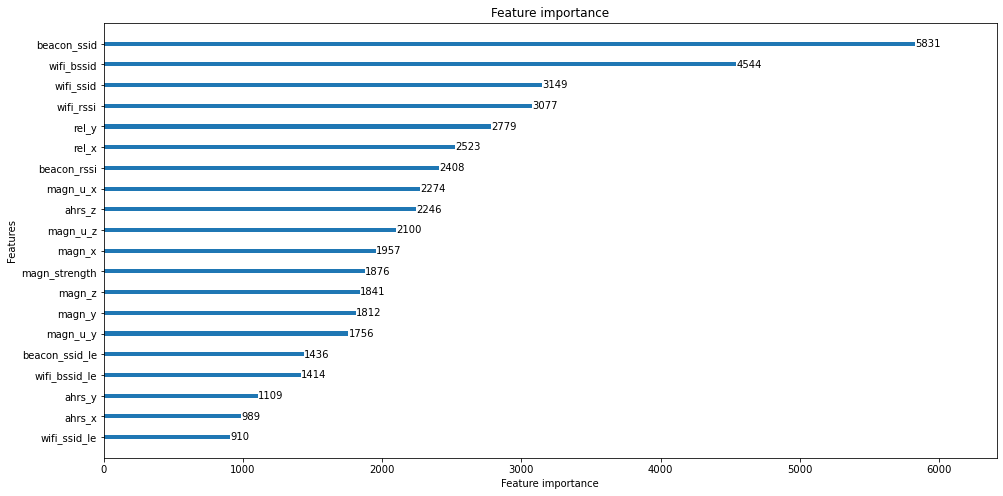

In [13]:
lgb.plot_importance(d["model_x"], max_num_features=20, grid=False, figsize=(16,8))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

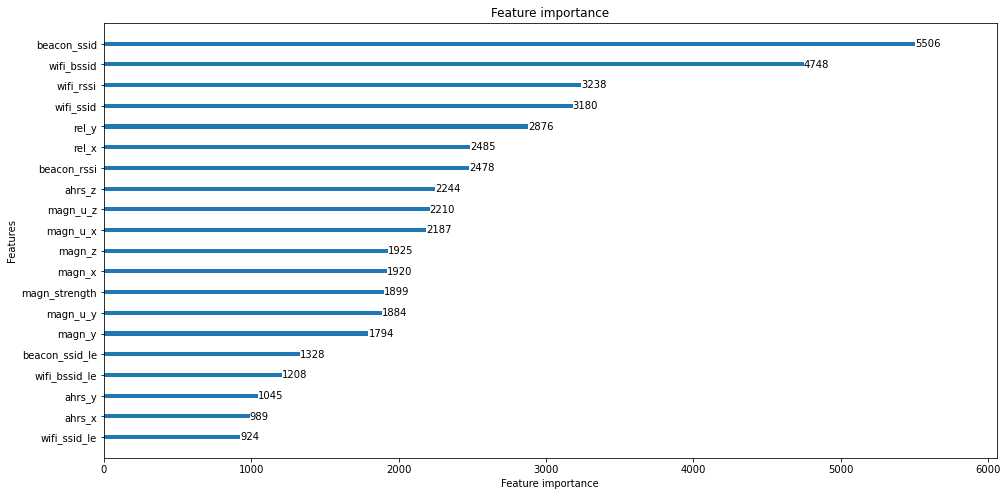

In [14]:
lgb.plot_importance(d["model_y"], max_num_features=20, grid=False, figsize=(16,8))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

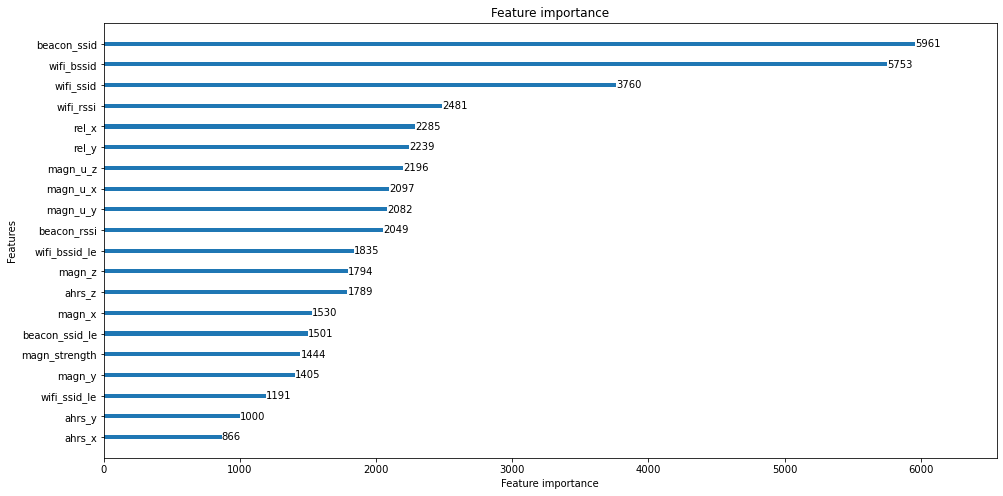

In [15]:
lgb.plot_importance(d["model_f"], max_num_features=20, grid=False, figsize=(16,8))

In [ ]:
# Prepare new d
d = {}

In [ ]:
# Try RF

# lgb patams
lgb_params = {'objective': 'root_mean_squared_error',
              'boosting_type': 'rf',
              'n_estimators': 50000, # example had 50000
              'learning_rate': 0.1,
              'num_leaves': 50,
              'min_data_in_leaf': 50,
              'max_depth': 10,
              'colsample_bytree': 0.4,
              'subsample': 0.6,
              'subsample_freq': 2,
              'bagging_seed': SEED,
              'reg_alpha': 8,
              'reg_lambda': 2,
              'random_state': SEED,
              'n_jobs': -1
              }

# train models
for tgt in targets:
    model = lgb.train(params=lgb_params,
                      train_set=d["train_{}".format(tgt)],
                      early_stopping_rounds=20,
                      valid_sets=d["val_{}".format(tgt)])
    d["model_{}".format(tgt)] = model
    d["pred_target_{}".format(tgt)] = model.predict(d["feat_val_{}".format(tgt)], 
                                                    num_iteration=model.best_iteration)

In [ ]:
print(d.keys())
print(len(d["target_val_f"]))
print(len(d["pred_target_f"]))
# print(np.argwhere(np.isnan(list(d["target_val_f"]))))

# the below code should not be there once the model has proper floor_map
d["target_val_f"] = [0 if math.isnan(x) else x for x in d["target_val_f"]]

In [ ]:
mse_x = mean_squared_error(d["target_val_x"], d["pred_target_x"])
mse_y = mean_squared_error(d["target_val_y"], d["pred_target_y"])
mse_f = mean_squared_error(d["target_val_f"], d["pred_target_f"])
rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)
rmse_f = np.sqrt(mse_f)
print("rmse_x:", rmse_x, "rmse_y:",rmse_y, "rmse_f:",rmse_f)

In [ ]:
comp_metric = comp_metric(d["pred_target_x"], d["pred_target_y"], d["pred_target_f"], 
                          d["target_val_x"].to_numpy(), d["target_val_y"].to_numpy(), d["target_val_f"])

print("comp metric: ", comp_metric)

In [ ]:
# Visualize feature importance
lgb.plot_importance(d["model_x"], max_num_features=15, grid=False, figsize=(16,5))

In [ ]:
lgb.plot_importance(d["model_y"], max_num_features=15, grid=False, figsize=(16,5))

In [ ]:
lgb.plot_importance(d["model_f"], max_num_features=15, grid=False, figsize=(16,5))

In [ ]:
# Try MLP
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

In [ ]:
# column settings
drop_cols = ["site_id", "file_id", "wifi_ssid", "wifi_bssid", \
             "floor_converted", "floor", "x", "y", "floor_converted_le", \
             "acce_acc", "ahrs_acc", "magn_acc", "wifi_freq"]
datetime_features = ["ts_date", "ts_day", "ts_hour", "ts_minute", \
                     "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
                     "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"]
    
# convert to int from datetime64 dtype
for col in datetime_features:
    df_train[col] = df_train[col].astype(int)

# set features and labels
# print(df_train.info())

features = df_train.drop(columns=drop_cols)
target_x = df_train.iloc[:, 5]
target_y = df_train.iloc[:, 6]
target_f = df_train.iloc[:, 2]

targets = ["x", "y", "f"]
target_data = [target_x, target_y, target_f]

d = {}
for tgt, tgt_data in zip(targets, target_data):
    feat_train, feat_val, target_train, target_val = \
    train_test_split(features, tgt_data, test_size = 0.2, random_state = 42)
    d["feat_train_{}".format(tgt)] = feat_train
    d["feat_val_{}".format(tgt)] = feat_val
    d["target_train_{}".format(tgt)] = target_train
    d["target_val_{}".format(tgt)] = target_val
#     d["train_{}".format(tgt)] = lgb.Dataset(data=feat_train, label=target_train, categorical_feature=categorical_features, free_raw_data=False).construct()
#     d["val_{}".format(tgt)] = lgb.Dataset(data=feat_val, label=target_val, categorical_feature=categorical_features, free_raw_data=False).construct()
    print(d["feat_train_{}".format(tgt)].shape)
    print(d["feat_val_{}".format(tgt)].shape)
    print(d["target_train_{}".format(tgt)].shape)
    print(d["target_val_{}".format(tgt)].shape)
#     print(d["train_{}".format(tgt)].get_data().shape)
#     print(d["train_{}".format(tgt)].get_label().shape)
#     print(d["val_{}".format(tgt)].get_data().shape)
#     print(d["val_{}".format(tgt)].get_label().shape)

In [ ]:
display(feat_train.head())
display(feat_val.head())
print(len(feat_train))
print(len(feat_val))
print(len(target_train))
print(len(target_val))
print(feat_train.shape)
print(feat_val.shape)

for tgt in targets:
    print(f"feat_train_{tgt}", d["feat_train_{}".format(tgt)].shape)
    print(f"feat_val_{tgt}", d["feat_val_{}".format(tgt)].shape)
    print(f"target_train_{tgt}", d["target_train_{}".format(tgt)].shape)
    print(f"target_val_{tgt}", d["target_val_{}".format(tgt)].shape)

In [ ]:
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_converted_le"]
# features = df_train.drop(columns=drop_cols)


In [ ]:
# Try MLP
# feat_train, feat_val, target_train, target_val

# hyper parameters
input_size = feat_train.shape[1]
print(input_size)
output_size = 1
num_epochs = 5000
learning_rate = 0.1


# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(d["feat_train_y"])
X_test = scaler.transform(d["feat_val_y"])

y_train = np.expand_dims(d["target_train_y"], axis=1)
y_test = np.expand_dims(d["target_val_y"], axis=1)

# linear regression model
class LinearRegression(nn.Module):

    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear_1 = nn.Linear(input_size, input_size)
        self.linear_2 = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.linear_1(x)
        out = self.linear_2(x)
        return out

model = LinearRegression(input_size, output_size)
print(model)

# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(X_train, y_train):
#     print("X: ", X_train[0])
#     print("X shape: ", X_train.shape)
#     print("y: ", y_train[0])
#     print("y shape: ", y_train.shape)
    inputs = torch.from_numpy(X_train).float()
    targets = torch.from_numpy(y_train).float()
#     print(inputs.shape)
#     print(targets.shape)

    optimizer.zero_grad()
    outputs = model(inputs)
#     print(outputs.shape)

    loss = torch.sqrt(criterion(outputs, targets)) # Use RMSE not MSE so we can compare with lgbm baseline
    loss.backward()
    optimizer.step()

    return loss.item()

def valid(X_test, y_test):
    inputs = torch.from_numpy(X_test).float()
    targets = torch.from_numpy(y_test).float()
    
    outputs = model(inputs)
    val_loss = torch.sqrt(criterion(outputs, targets)) # Use RMSE not MSE
    
    return val_loss.item()
        
# train the model
loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    loss = train(X_train, y_train)
    val_loss = valid(X_test, y_test)
#     print(loss)
#     print(val_loss)

    if epoch % 200 == 0:
        print('epoch %d, loss: %.4f val_loss: %.4f' % (epoch, loss, val_loss))

    loss_list.append(loss)
    val_loss_list.append(val_loss)

# plot learning curve
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()

In [ ]:
# Run MLP prediction
# Calculate comp_metric score

In [ ]:
# # Load test data
# df_test_pred = df_test.drop(columns=drop_cols)

# # Add "site_path_timestamp" column to df_test
# # convert ts to unix and then convert it to string, and put it in a new column["ts_unix"]
# # join ["site_id", "file_id", "ts_unix"] and put it into a new column ["site_path_timestamp"]
# # or just add it when generating the data -> less steps -> less likely to make a mistake

# test_preds_x = model_x.predict(df_test_pred)
# test_preds_y = model_y.predict(df_test_pred)
# test_preds_f = model_f.predict(df_test_pred)

# # stack the results up with the pairing site_path_timestamp
# # load ssubm
# # test_preds = pd.concat([test_preds_x, test_preds_y, test_preds_f], axis=1)
# test_preds.columns = ssubm.columns
# test_preds.index = df_test_pred["site_path_timestamp"]
# test_preds["floor"] = test_preds["floor"].astype(int)
# predictions.append(test_preds)

In [ ]:
# generate prediction file 
# pd.concat(predictions)
# reindex the prediction df
# convert to csv for submission